# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    if state.get('old_grad'):
        flag = True
        old_dx = state['old_grad']
    else:
        flag = False
        old_dx = dx
    for cur_layer_x, cur_layer_dx, cur_layer_old_dx in zip(x,dx, old_dx): 
        for cur_x, cur_dx, cur_old_dx in zip(cur_layer_x,cur_layer_dx, cur_layer_old_dx):
            cur_old_grad = (config['momentum'] * cur_old_dx) if flag else 0 + config['learning_rate'] * cur_dx
            np.add(cur_x, -cur_old_grad, out=cur_x)
    old_dx = dx.copy()

In [4]:
def accuracy(A, B):
    return np.sum(np.argmax(A,axis=-1) == np.argmax(B, axis=-1)) * 1. / A.shape[0]

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

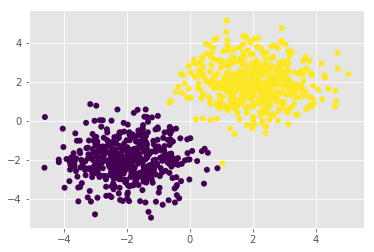

In [5]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [6]:
criterion = ClassNLLCriterion()


# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(SoftMax())

net = Sequential()
net.add(Linear(2, 10))
net.add(ReLU())
net.add(Linear(10, 10))
net.add(ReLU())
net.add(Linear(10, 10))
net.add(ReLU())
net.add(Linear(10, 2))
net.add(SoftMax())


print(net)

Linear 2 -> 10
ReLU
Linear 10 -> 10
ReLU
Linear 10 -> 10
ReLU
Linear 10 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [7]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.005, 'momentum': 0.1}
optimizer_state = {}

# Looping param2
n_epoch = 30
batch_size = 128

In [8]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [9]:
dens = 100
m_X1,m_X2 = np.meshgrid(np.linspace(-6,6,dens), np.linspace(-6,6,dens+1))
m_X1 = m_X1.flatten()
m_X2 = m_X2.flatten()

Accuracy: 0.999


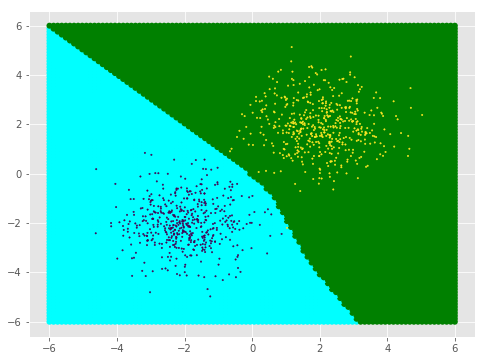

KeyboardInterrupt: 

In [10]:
loss_history = []

for i in range(n_epoch):
#     print('Epoch:',i,'Accuracy:',accuracy( net.forward(X), Y))
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        predictions = net.forward(X)
        loss = criterion.forward(predictions, Y)

        net.zeroGradParameters()
        
        # Forward
        
        predictions = net.forward(x_batch)
        criterion.forward(predictions, y_batch)
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    acc = accuracy( net.forward(X), Y)

    m_y = net.forward(np.column_stack((m_X1,m_X2))).argmax(axis=1) 
    m_c = ['cyan' if x else 'green' for x in m_y]
    display.clear_output(wait=True)

    plt.figure(figsize=(8, 6))
    plt.scatter(m_X1,m_X2, c=m_c, edgecolors= 'none')
    plt.scatter(X[:,0],X[:,1], c=Y[:,0], s=2)
    print('Accuracy:',acc)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show() 
